In [1]:
import pandas as pd
import numpy as np
import glob
import os
import geopandas as gpd
import urllib
import sys
import pathlib
import glob
import matplotlib.pyplot as plt
from urllib.parse import quote
from sqlalchemy import create_engine
import configparser


import statsmodels.api as sm
#import pingouin as pg
import plotly.express as px



In [2]:
sys.path.append("G:/Shared drives/UGS_Flux/Data_Processing/Jupyter_Notebooks/Micromet")
#sys.path.append("../../Micromet")
import micromet

%matplotlib inline

In [7]:
site_folders = {'US-UTD':'Dugout_Ranch',
                'US-UTB':'BSF',
                'US-UTJ':'Bluff',
                'US-UTW':'Wellington',
                'US-UTE':'Escalante',
                'US-UTM':'Matheson',
                'US-UTP':'Phrag',
                'US-CdM':'Cedar_mesa',
                'US-UTV':'Desert_View_Myton',
                'US-UTN':'Juab'
                }


compdf = {}


for key, value in site_folders.items():

    print(key)
    raw_fold = pathlib.Path('H:/UGS_Flux/Data_Downloads/')
    raw_data = micromet.raw_file_compile(raw_fold, value, search_str = "*Flux_AmeriFluxFormat*.dat")
    if raw_data is not None:
        am_data = micromet.Reformatter(raw_data)
        am_df = am_data.et_data
        compdf[key] = am_df

        am_df.to_csv(f"../station_data/{key}_HH_{am_df['TIMESTAMP_START'].values[0]:}_{am_df['TIMESTAMP_END'].values[-1]:}.csv")
        #am_df['stationid'] = key
        
        #am_df.to_sql('amfluxeddy', key, engine, if_exists='append',schema='groundwater')
        
cdf = pd.concat(compdf,axis=0)
cdf.index.set_names(['stationid','datetime_start'],inplace=True)
#cdf.rename(columns={'level_0':'stationid'},inplace=True)
#cdf.to_parquet('../station_data/all_data.parquet')
for col in cdf.columns:
    cdf.rename(columns={col:col.lower()},inplace=True)
#cdf.to_sql(name = 'amfluxeddy',schema='groundwater', con=engine, if_exists='replace', chunksize=2000)

US-UTP


ValueError: invalid literal for int() with base 10: '(2)'

In [18]:
raw_fold = pathlib.Path('H:/UGS_Flux/Data_Downloads/Wellington')
value = 'm20240723'
raw_met_data = micromet.raw_file_compile(raw_fold, value, search_str = "*AmeriFlux*.dat")

print(pd.to_datetime(raw_met_data['TIMESTAMP_START'][0],format='%Y%m%d%H%M'))

raw_met_data['datetime'] = pd.date_range(start='2024-07-11 06:00:00', freq='30min', periods=len(raw_met_data))
raw_met_data.set_index('datetime', inplace=True)
#micromet.Reformatter(raw_met_data)

Encountered an error with file H:\UGS_Flux\Data_Downloads\Wellington\m20240723\21023.Ameriflux.dat: 'utf-8' codec can't decode byte 0xd0 in position 2048: invalid continuation byte
2024-07-11 05:47:00


In [84]:
data.rename(columns={'WD':'csat_WD'})['csat_WD']

datetime_start
2024-07-11 00:00:00    206.05460
2024-07-11 00:30:00    228.14360
2024-07-11 01:00:00    201.98320
2024-07-11 01:30:00    220.81300
2024-07-11 02:00:00    196.60210
                         ...    
2024-07-23 09:30:00     36.73117
2024-07-23 10:00:00     28.86353
2024-07-23 10:30:00    171.83480
2024-07-23 11:00:00    146.09880
2024-07-23 11:30:00    154.43910
Name: csat_WD, Length: 600, dtype: float64

In [137]:
df_wd = pd.concat([data.rename(columns={'WD':'csat_WD','WS':'csat_WS'}),
                  raw_met_data.rename(columns={'WD':'young_WD','WS':'young_WS'}).shift(-1)], axis=1)
df_wd = df_wd[['csat_WD','young_WD','csat_WS','young_WS']].dropna(axis=1, how='all')
df_wd['csat_wd_rad'] = pg.circ_axial(pg.convert_angles(df_wd['csat_WD'],positive=True),2)
csat_wd_mean = pg.circ_mean(pg.convert_angles(df_wd['csat_WD']))
df_wd['young_wd_rad'] = pg.circ_axial(pg.convert_angles(df_wd['young_WD'],positive=True),2)
young_wd_mean = pg.circ_mean(pg.convert_angles(df_wd['young_WD']))



print(csat_wd_mean, young_wd_mean)
pg.circ_corrcc(df_wd['csat_wd_rad'], df_wd['young_wd_rad'], correction_uniform=True)

-1.0158989110862817 -1.6429189571204086


(0.9261544168103398, 1.9666946764465225e-78)

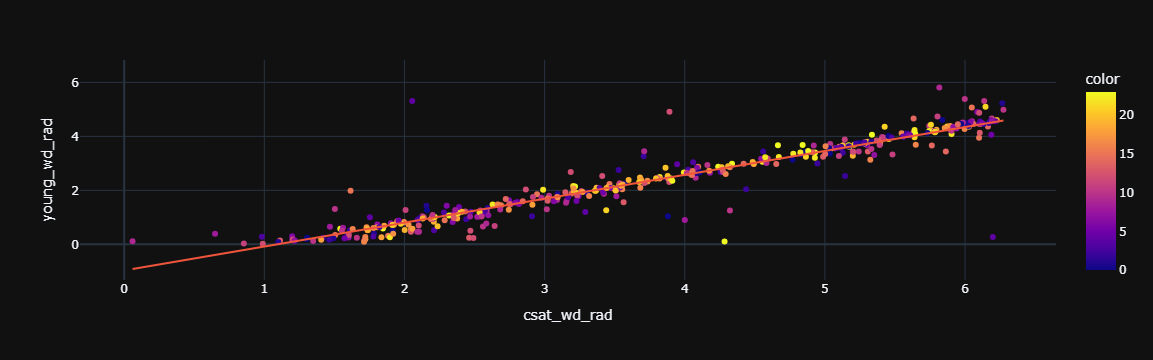

In [138]:
df_wd.loc[(df_wd['young_wd_rad']>3.2) & (df_wd['csat_wd_rad']<2),'csat_wd_rad'] = df_wd.loc[(df_wd['young_wd_rad']<3.2) & (df_wd['csat_wd_rad']>2),'csat_wd_rad'] + 6.25

fig = px.scatter(df_wd, x='csat_wd_rad', y='young_wd_rad', trendline="ols",color=df_wd.index.hour)
fig.show()

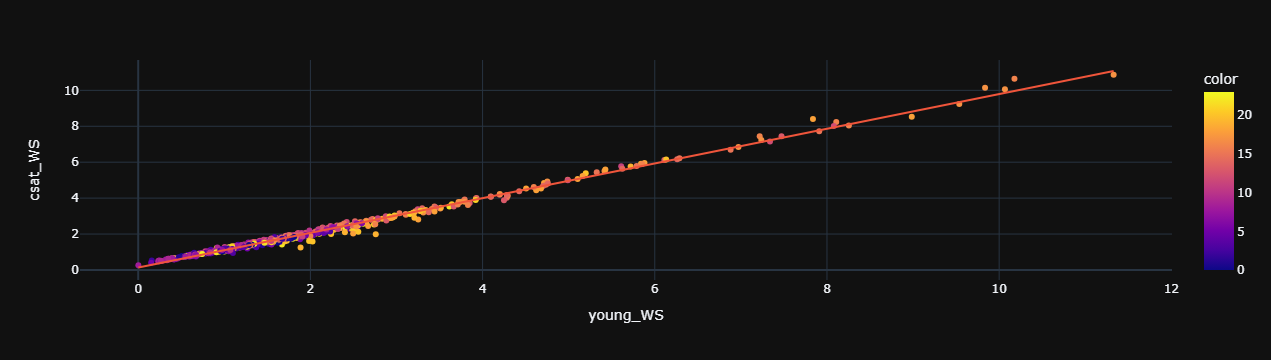

In [113]:

#fig = px.line(df_wd, y=["young_WS","csat_WS"],
#              title='custom tick labels')
fig = px.scatter(df_wd, x='young_WS', y='csat_WS', trendline="ols",color=df_wd.index.hour)
fig.show()

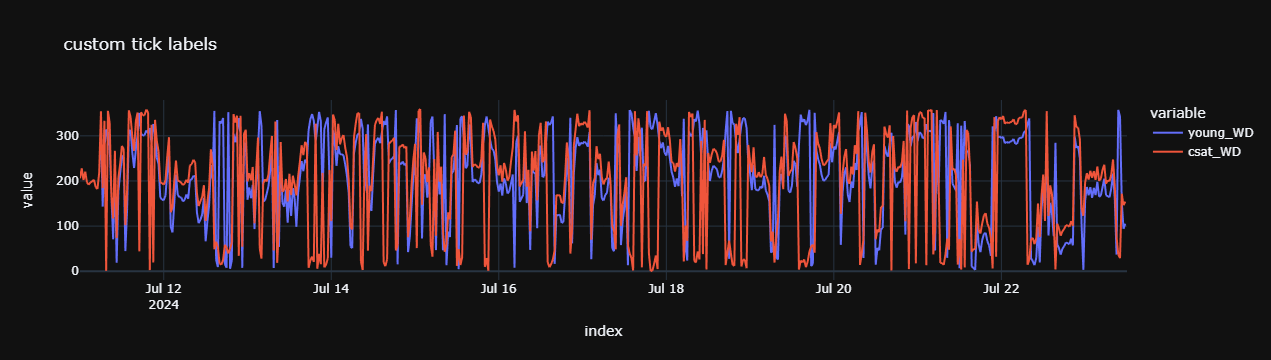

In [107]:


fig = px.line(df_wd, y=["young_WD","csat_WD"],
              title='custom tick labels')

fig.show()

const        38.679838
LW_OUT_AP     0.923404
dtype: float64


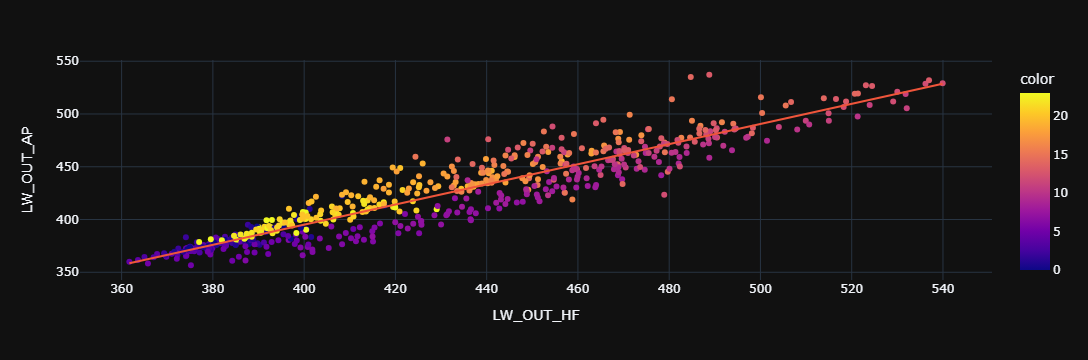

                            OLS Regression Results                            
Dep. Variable:              LW_OUT_HF   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     4376.
Date:                Thu, 25 Jul 2024   Prob (F-statistic):          9.85e-274
Time:                        15:56:59   Log-Likelihood:                -2378.9
No. Observations:                 587   AIC:                             4762.
Df Residuals:                     585   BIC:                             4771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.6798      5.937      6.515      0.0

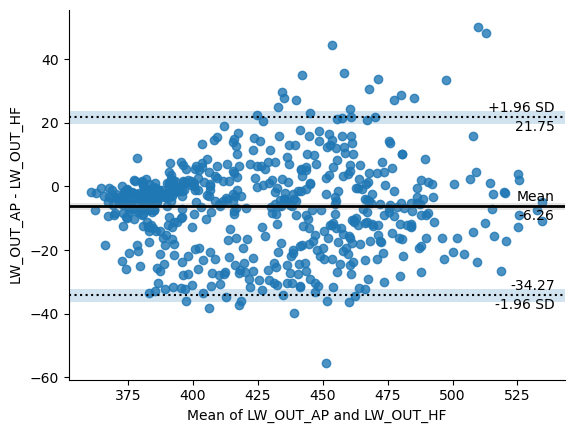

In [109]:
#raw_met_data['SW_IN'].plot()

comp_col = 'LW_OUT'

sql = "SELECT * FROM groundwater.amfluxeddy WHERE (groundwater.amfluxeddy.stationid = 'US-UTW') AND (groundwater.amfluxeddy.timestamp_start >= 202407110000)"
data = pd.read_sql(sql, con=engine)
data = data.replace(-9999, np.nan)
data.set_index('datetime_start', inplace=True)
for col in data.columns:
    data.rename(columns={col:col.upper()}, inplace=True)
#data['SW_IN'].plot()

df = pd.concat([data.rename(columns={f'{comp_col}':f'{comp_col}_HF'})[f'{comp_col}_HF'].shift(-1),
                raw_met_data.rename(columns={f'{comp_col}':f'{comp_col}_AP'})[f'{comp_col}_AP']],axis=1).dropna()


y = df[f'{comp_col}_HF']
x = df[f'{comp_col}_AP']
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
print(results.params)



fig = px.scatter(df, x=f'{comp_col}_HF', y=f'{comp_col}_AP', trendline="ols",color=df.index.hour)

ax = pg.plot_blandaltman(x, y)

fig.show()
print(results.summary())

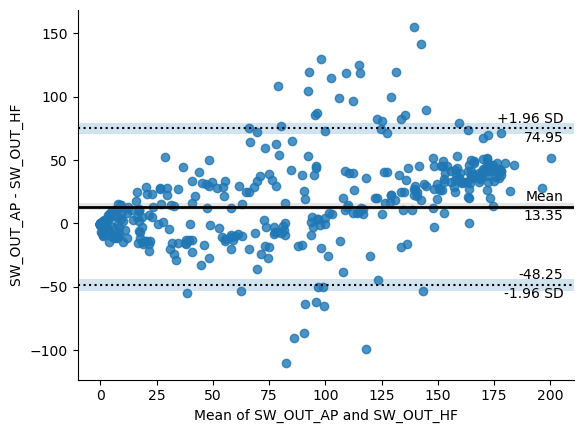

In [67]:
d = pg.plot_blandaltman(x, y)

(13.348921055466418,
 31.39937720750009,
 array([ 1.72552250e+01,  3.09366650e+01,  5.38590350e+01,  7.37166550e+01,
         9.43441800e+01,  1.15017100e+02,  1.29100050e+02,  1.39749000e+02,
         1.49640200e+02,  1.57404300e+02,  1.64553100e+02,  1.68396700e+02,
         1.71062350e+02,  1.72854950e+02,  1.72610250e+02,  1.71765150e+02,
         1.70113350e+02,  1.66099300e+02,  1.58430600e+02,  1.48149350e+02,
         1.36654850e+02,  9.24395550e+01,  6.96543200e+01,  8.95328050e+01,
         6.94718050e+01,  4.81761750e+01,  2.63490200e+01,  9.06921450e+00,
         1.17125535e+00,  7.57496400e-01,  6.07974100e-01,  3.65336000e-02,
         2.24365000e-03,  6.33733400e-01,  2.87200050e-01,  4.43032100e-02,
         3.47603500e-02,  4.62243650e-01, -2.24502000e-02,  2.06977300e-01,
         6.97332500e-02,  1.55267705e+00,  8.01177600e+00,  2.21245800e+01,
         4.09008000e+01,  6.10189000e+01,  8.13820600e+01,  1.00046800e+02,
         1.16815400e+02,  1.30854400e+02,  1.40

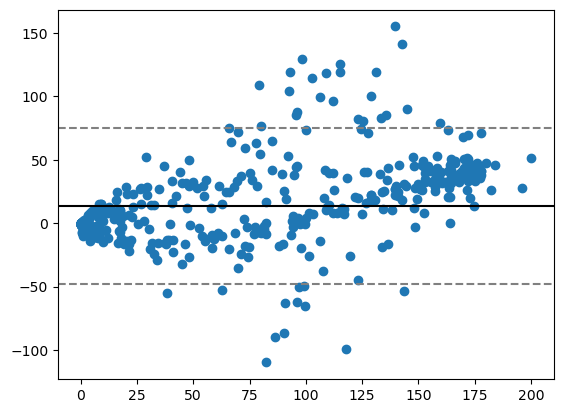

In [68]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    return md, sd, mean, CI_low, CI_high

md, sd, mean, CI_low, CI_high = bland_altman_plot(x,y)

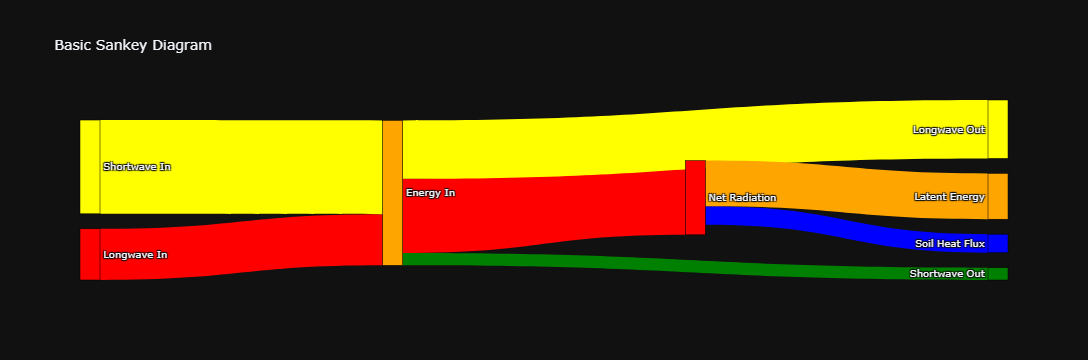

In [161]:
import plotly.graph_objects as go

dt_tm = pd.to_datetime('2024-07-15 11:00')
lwin  = data.loc[dt_tm,'LW_IN']
lwout = data.loc[dt_tm,'LW_OUT']
swin = data.loc[dt_tm,'SW_IN']
swout = data.loc[dt_tm,'SW_OUT']
shf = data.loc[dt_tm,'G']
le = data.loc[dt_tm,'LE']
h = data.loc[dt_tm,'H']
netrad = data.loc[dt_tm,'NETRAD']


import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = ["Longwave In", "Shortwave In","Energy In", "Net Radiation","Longwave Out", "Shortwave Out","Soil Heat Flux","Latent Energy","Sensible Heat"],
        color = ['red','yellow','orange','red','yellow','green','blue','orange']
    ),
    link = dict(
        source = [0,1,2,2,2,3,3,3,], # indices correspond to labels, eg A1, A2, A1, B1, ...
        target = [2,2,3,4,5,6,7,8,],
        value = [lwin,swin,netrad,lwout,swout,shf,le,h],
        color = ['red','yellow','red','yellow','green','blue','orange']
    ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [150]:
data.loc[dt_tm,'ALB']

12.07613

In [62]:
print(df.ptests(paired=True, stars=False))

          SW_OUT_HF SW_OUT_AP
SW_OUT_HF         -     0.000
SW_OUT_AP    -9.833         -


C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\pingouin\pairwise.py:763: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [23]:
sql = "SELECT * FROM groundwater.amfluxeddy WHERE groundwater.amfluxeddy.stationid = 'US-UTW'"
data = pd.read_sql(sql, con=engine, )

data

,stationid,datetime_start,RECORD,TIMESTAMP_START,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,...,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1,T_CANOPY
0,US-UTW,2021-05-20 08:30:00,3050,202105200830,202105200900,407.2644,5.005207,7.278824,1.165805,-21.22704,...,30.644530,-0.491092,16.76229,33.57438,0.610996,-9999.00000,2056.1460,13.80275,26.85778,None
1,US-UTW,2021-05-20 09:00:00,3051,202105200900,202105200930,407.7179,5.687793,6.741088,1.327115,-19.22281,...,25.603640,-1.606802,18.31725,28.80552,-0.181496,-9999.00000,1627.3620,14.42237,26.86310,None
2,US-UTW,2021-05-20 09:30:00,3052,202105200930,202105201000,406.3490,4.168286,6.139927,1.284270,-22.90472,...,20.779270,-2.921037,20.16849,24.21374,-0.998767,-9999.00000,1125.0460,15.11649,26.91096,None
3,US-UTW,2021-05-20 10:00:00,3053,202105201000,202105201030,406.7009,3.976950,5.667840,1.149024,-26.63531,...,18.309870,-3.968961,20.94458,21.54570,-1.909985,-9999.00000,1380.7430,15.70732,26.96453,None
4,US-UTW,2021-05-20 10:30:00,3054,202105201030,202105201100,406.4454,3.858029,5.672696,1.118326,-32.14391,...,17.935150,-3.953480,21.33583,21.08741,-1.873573,-9999.00000,1287.0830,16.31986,26.98232,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55682,US-UTW,2024-07-23 09:30:00,-9999,202407230930,202407231000,368.6032,10.575600,6.478619,2.332695,-24.38892,...,15.563250,-2.410295,-9999.00000,98.95328,58.845180,27.89410,2023.6170,19.60121,34.10001,None
55683,US-UTW,2024-07-23 10:00:00,-9999,202407231000,202407231030,361.4945,13.314320,7.708470,3.197085,-39.83874,...,17.161540,-0.370931,-9999.00000,98.95437,58.846450,29.03444,1630.6980,20.13686,34.21332,None
55684,US-UTW,2024-07-23 10:30:00,-9999,202407231030,202407231100,368.6760,11.926480,5.242767,2.674489,-26.70993,...,11.141980,-6.023516,-9999.00000,98.95482,58.846960,29.72257,1000.0000,20.75039,34.32639,None
55685,US-UTW,2024-07-23 11:00:00,-9999,202407231100,202407231130,366.6481,13.571160,5.333927,2.753507,-20.14796,...,11.519130,-5.848532,-9999.00000,98.95490,58.847080,28.92892,145.6467,21.26992,34.42508,None


In [ ]:
cdf = pd.read_parquet('station_config/station_data/all_data.parquet')
cdf.replace(-9999,np.nan,inplace=True)
cdf['le_pos'] = cdf['LE'].apply(lambda x: np.nan if x < 0 else x)
cdf['et_pos'] = cdf['ET'].apply(lambda x: np.nan if x < 0 else x)

utw= cdf.loc['US-UTW']#.loc[pd.to_datetime('2021-01-15'):pd.to_datetime('2022-07-14')].copy(deep=True)

utw = utw.dropna(axis=1, how='all')
#for col in utd.columns:
#    if "SSITC" in col:
#        utd.drop([col],axis=1,inplace=True)
#td.drop(['station','TIMESTAMP_END','TIMESTAMP_START'],axis=1,inplace=True)

In [ ]:
cdf

In [ ]:
import plotly.express as px
import pandas as pd


fig = px.line(utw, x=utw.index, y=['SWC_1_1_1','SWC_2_1_1'], title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

cdf = pd.read_parquet('station_config/station_data/all_data.parquet')
cdf.replace(-9999,np.nan,inplace=True)
cdf['le_pos'] = cdf['LE'].apply(lambda x: np.nan if x < 0 else x)
cdf['et_pos'] = cdf['ET'].apply(lambda x: np.nan if x < 0 else x)

utw= cdf.loc['US-UTW']#.loc[pd.to_datetime('2021-01-15'):pd.to_datetime('2022-07-14')].copy(deep=True)

utw = utw.dropna(axis=1, how='all')



def find_irr_dates(df, swc_col='SWC_1_1_1', do_plot=False, dist=20, height=35, prom=0.5):
    """
    Finds irrigation dates within a DataFrame.

    :param df: A pandas DataFrame containing the data.
    :param swc_col: String. The column name in 'df' containing the soil water content data. Should be in units of percent and not a decimal; Default is 'SWC_1_1_1'.
    :param do_plot: Boolean. Whether to plot the irrigation dates on a graph. Default is False.
    :param dist: Integer. The minimum number of time steps between peaks in 'swc_col'. Default is 20.
    :param height: Integer. The minimum height (vertical distance) of the peaks in 'swc_col'. Default is 35(%).
    :param prom: Float. The minimum prominence of the peaks in 'swc_col'. Default is 0.5.

    :return: A tuple containing the irrigation dates and the corresponding soil water content values.
    """
    df_irr_season = df[df.index.month.isin([4,5,6,7,8,9,10])]
    peaks, _ = find_peaks(df_irr_season[swc_col], distance=dist, height=height,prominence=(prom,None))
    dates_of_irr = df_irr_season.iloc[peaks].index
    swc_during_irr = df_irr_season[swc_col].iloc[peaks]
    if do_plot:
        plt.plot(df.index,df[swc_col])
        plt.plot(dates_of_irr,swc_during_irr, "x")
        plt.show()
    return dates_of_irr, swc_during_irr

find_irr_dates(utw, 'SWC_1_1_1',do_plot=True)

In [ ]:
utw.iloc[peaks].index

In [ ]:
camp = pd.read_csv("C:/Users/paulinkenbrandt/Downloads/Wellington_Flux_CSFormat.dat",skiprows=[0,2,3],index_col='TIMESTAMP',
                   parse_dates=True)
camp = camp[camp.index < pd.to_datetime('2025-01-01')]
fig = px.line(camp, x=camp.index, y='TA_1_1_1', title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

camp

In [ ]:
fig = px.line(utw, x=utw.index, y=['TA_1_1_1','TA_1_2_1','TA_1_3_1'], title='Time Series with Rangeslider')

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=0, max_iter=30, missing_values=np.nan,
                            sample_posterior=True,n_nearest_features=100,)
imp_mean.fit(utd)
#X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
new_utd = pd.DataFrame(imp_mean.transform(utd), columns=utd.columns)
utd['imp_LE'] = new_utd['LE']


In [ ]:
fig = px.line(utd, y=['LE'], title='Time Series with Range Slider and Selectors')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [ ]:


new_utd.index = utd.index
new_utd['NETRAD'].resample('1D').sum().plot()
new_utd['LE'].resample('1D').sum().plot()
new_utd['G'].resample('1D').sum().plot()
new_utd['H'].resample('1D').sum().plot()


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

dlybalance = new_utd[['LE','NETRAD','G','H']].resample('1D').sum()#.plot()
plt.scatter(dlybalance['LE']+dlybalance['H'],dlybalance['NETRAD']-dlybalance['G'])
plt.plot([1000,8000],[1000,8000])
plt.grid()

In [ ]:
pd.read_csv(r"C:\Users\paulinkenbrandt\Downloads\Dugout Ranch_Flux_AmeriFluxFormat.dat",skiprows=[0,2,3])

In [ ]:
sql = "SELECT * FROM groundwater.amfluxeddy"
df = pd.read_sql(sql, engine)
existing = df.station.unique()

site_folders = {'US-UTD':'Dugout_Ranch','US-UTB':'BSF','US-UTJ':'Bluff','US-UTW':'Wellington','US-UTE':'Escalante',
                'US-UTM':'Matheson','US-UTP':'Phrag','US-CdM':'Cedar_mesa','US-UTV':'Desert_View_Myton'}

for key, value in site_folders.items():
    if key in existing:
        pass
    else:
        print(key)
        raw_fold = pathlib.Path('H:/UGS_Flux/Data_Downloads/')
        raw_data = flux_network.raw_file_compile(raw_fold, value)
        if raw_data is not None:
            am_data = flux_network.Reformatter(raw_data)
    
            am_df = am_data.et_data
            am_df['station'] = key
            am_df = flux_network.remove_extra_soil_params(am_df)
    
            print(len(raw_data))
            print(len(am_df))
    
            am_df.to_sql(name = 'amfluxeddy',schema='groundwater', con=engine, if_exists='append', chunksize=2000)
            #am_df.to_csv(f'{key}_amfluxeddy.csv')

In [ ]:
sql = "SELECT * FROM groundwater.amfluxeddy"
df = pd.read_sql(sql, engine)
statdf = df.set_index(['station','datetime_start'])
for station in statdf.index.get_level_values(0).unique():
    statdf.loc[station,'ET'].plot()

In [ ]:
statdf.loc['US-UTD']